# Neural Network Implementation: simulated data, *with* Dropout

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import seaborn as sns
import pymc3 as pm
plt.style.use('seaborn')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


-----

## The model:

In [55]:
?keras.Model

Init signature: keras.Model(inputs, outputs, name=None)
Docstring:     
The `Model` class adds training & evaluation routines to a `Container`.
    
File:           /anaconda3/envs/am207-project/lib/python3.6/site-packages/keras/engine/training.py
Type:           type


In [58]:
# Fit model according to specification in paper
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD
import keras.backend as K
from keras.callbacks import Callback
from keras.callbacks import LearningRateScheduler

# Euclidean loss function--obtained from:
# http://www.riptutorial.com/keras/example/32022/euclidean-distance-loss
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

# Implement learning rate schedule
# Adapted from examples at https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
def learning_schedule(epoch):
    base_lrate = 5e-3
    gamma = 0.0001
    p = 0.25
    lrate = base_lrate * (1 + gamma*140*epoch)**(-p)
    return lrate

# Based off of examples from:
# 1. https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
# 2. https://keras.io/getting-started/sequential-model-guide/#compilation

# Create NN dropout model
def create_model():
    # Create model
    
    # model = Sequential()
    
    # inputs
    inputs = keras.Input(shape=(1,))
    
    # Layer 1
    layer_1 = Dense(24, kernel_initializer='lecun_uniform', activation='tanh')(inputs)
    dropout_1 = Dropout(0.1)(layer_1, training=True)
   
    # Layer 2
    layer_2 = Dense(24, kernel_initializer='lecun_uniform', activation='tanh')(dropout_1)
    dropout_2 = Dropout(0.1)(layer_2, training=True)
   
    # Layer 3
    layer_3 = Dense(24, kernel_initializer='lecun_uniform', activation='tanh')(dropout_2)
    dropout_3 = Dropout(0.1)(layer_3, training=True)
   
    # Layer 4
    layer_4 = Dense(24, kernel_initializer='lecun_uniform', activation='tanh')(dropout_3)
    dropout_4 = Dropout(0.1)(layer_4, training=True)
    
    # Layer 5
    outputs = Dense(1, input_dim=24, kernel_initializer='lecun_uniform')(dropout_4)
    
    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    sgd = SGD(lr=5e-3, momentum=0.9, decay=5e-7, nesterov=False)
    model.compile(loss=euclidean_distance_loss, optimizer=sgd)
    return model

# Save predictions from every epoch
# Code from: https://stackoverflow.com/questions/36895627/python-keras-creating-a-callback-with-one-prediction-for-each-epoch?noredirect=1&lq=1


## Simulate the data:

In [105]:
xs = np.linspace(-1, 1, 200)*2*np.pi
#ys = xs - np.cos(xs) + np.sin(xs)
#ys = xs - np.cos(xs) + .2*np.sin(7*xs)
ys = -np.cos(xs)

train_mask = [False if i in range(20, 40) 
                   or i in range(80, 100) 
                   or i in range(130, 150)
              else True 
              for i in range(len(xs))]
test_mask = [not e for e in train_mask]

xs_train, ys_train = xs[train_mask], ys[train_mask]
xs_test, ys_test = xs[test_mask], ys[test_mask]

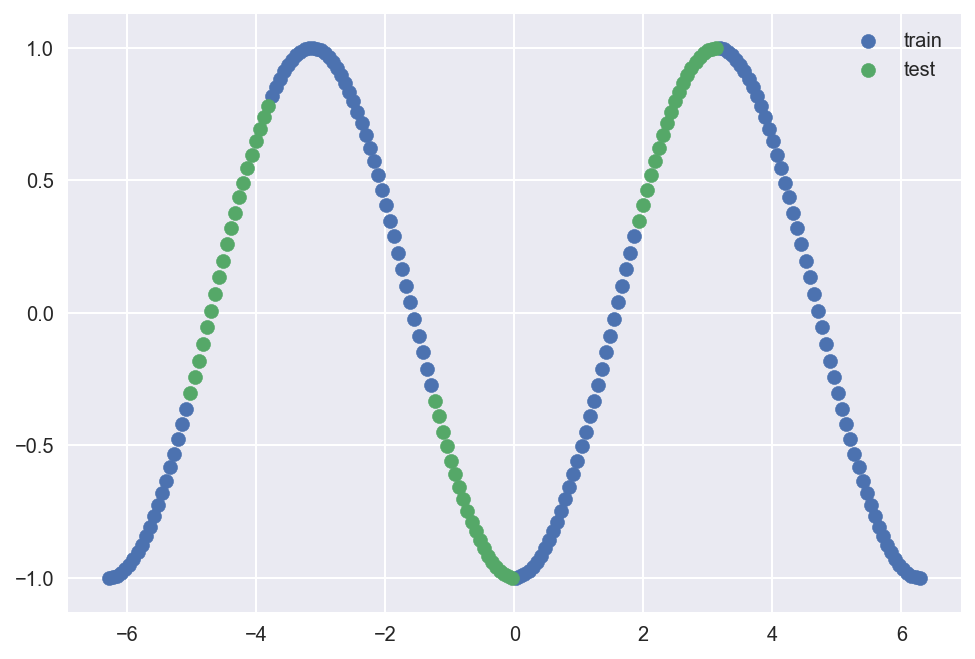

In [106]:
plt.scatter(xs_train, ys_train, label='train')
plt.scatter(xs_test, ys_test, label='test')
plt.legend();

## Train the model:

In [107]:
# Code for NBatchLogger class borrowed from https://github.com/keras-team/keras/issues/2850
# from the comment by user wenmin-wu
class NBatchLogger(Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display):
        self.step = 0
        self.display = display
        self.metric_cache = {}

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('epoch: {}... {}'.format(int(self.step/140),
                                          metrics_log))
            self.metric_cache.clear()

# class sim_prediction_history(Callback):
#     def __init__(self):
#         self.predhis = []
#     def on_epoch_end(self, epoch, logs={}):
#         self.predhis.append(sim_model.predict(xs))

nepochs = 5000
# predictions=sim_prediction_history()
lrate = LearningRateScheduler(learning_schedule)
out_batch = NBatchLogger(display=140*50)
# callbacks_list = [predictions, lrate, out_batch]
callbacks_list = [lrate, out_batch]

sim_model = create_model()
sim_model.fit(x=xs_train, y=ys_train, epochs=nepochs, batch_size=1, callbacks=callbacks_list, verbose=0)

epoch: 50...  - loss: 0.6419
epoch: 100...  - loss: 0.5131
epoch: 150...  - loss: 0.4411
epoch: 200...  - loss: 0.4126
epoch: 250...  - loss: 0.3792
epoch: 300...  - loss: 0.3208
epoch: 350...  - loss: 0.2811
epoch: 400...  - loss: 0.2731
epoch: 450...  - loss: 0.2462
epoch: 500...  - loss: 0.2394
epoch: 550...  - loss: 0.2225
epoch: 600...  - loss: 0.2248
epoch: 650...  - loss: 0.2216
epoch: 700...  - loss: 0.2145
epoch: 750...  - loss: 0.2192
epoch: 800...  - loss: 0.2113
epoch: 850...  - loss: 0.2055
epoch: 900...  - loss: 0.2064
epoch: 950...  - loss: 0.2078
epoch: 1000...  - loss: 0.2023
epoch: 1050...  - loss: 0.2000
epoch: 1100...  - loss: 0.1972
epoch: 1150...  - loss: 0.2025
epoch: 1200...  - loss: 0.1988
epoch: 1250...  - loss: 0.1979
epoch: 1300...  - loss: 0.1938
epoch: 1350...  - loss: 0.1917
epoch: 1400...  - loss: 0.1896
epoch: 1450...  - loss: 0.1924
epoch: 1500...  - loss: 0.1897
epoch: 1550...  - loss: 0.1886
epoch: 1600...  - loss: 0.1867
epoch: 1650...  - loss: 0.18

## Estimate uncertainty:

Here, we're computing many ($n=100$) **stochastic forward passes** through the network to get predictions

In [125]:
ys_pred = np.array([sim_model.predict(xs)[:, 0] for i in range(100)])

In [120]:
ys_pred.shape

(100, 200)

### Need to implement the methods from the paper; these estimates are just to get intutions going

In [121]:
ys_pred_mean = ys_pred.mean(axis=0)
ys_pred_sd = ys_pred.std(axis=0)

In [122]:
ys_pred_mean.shape

(200,)

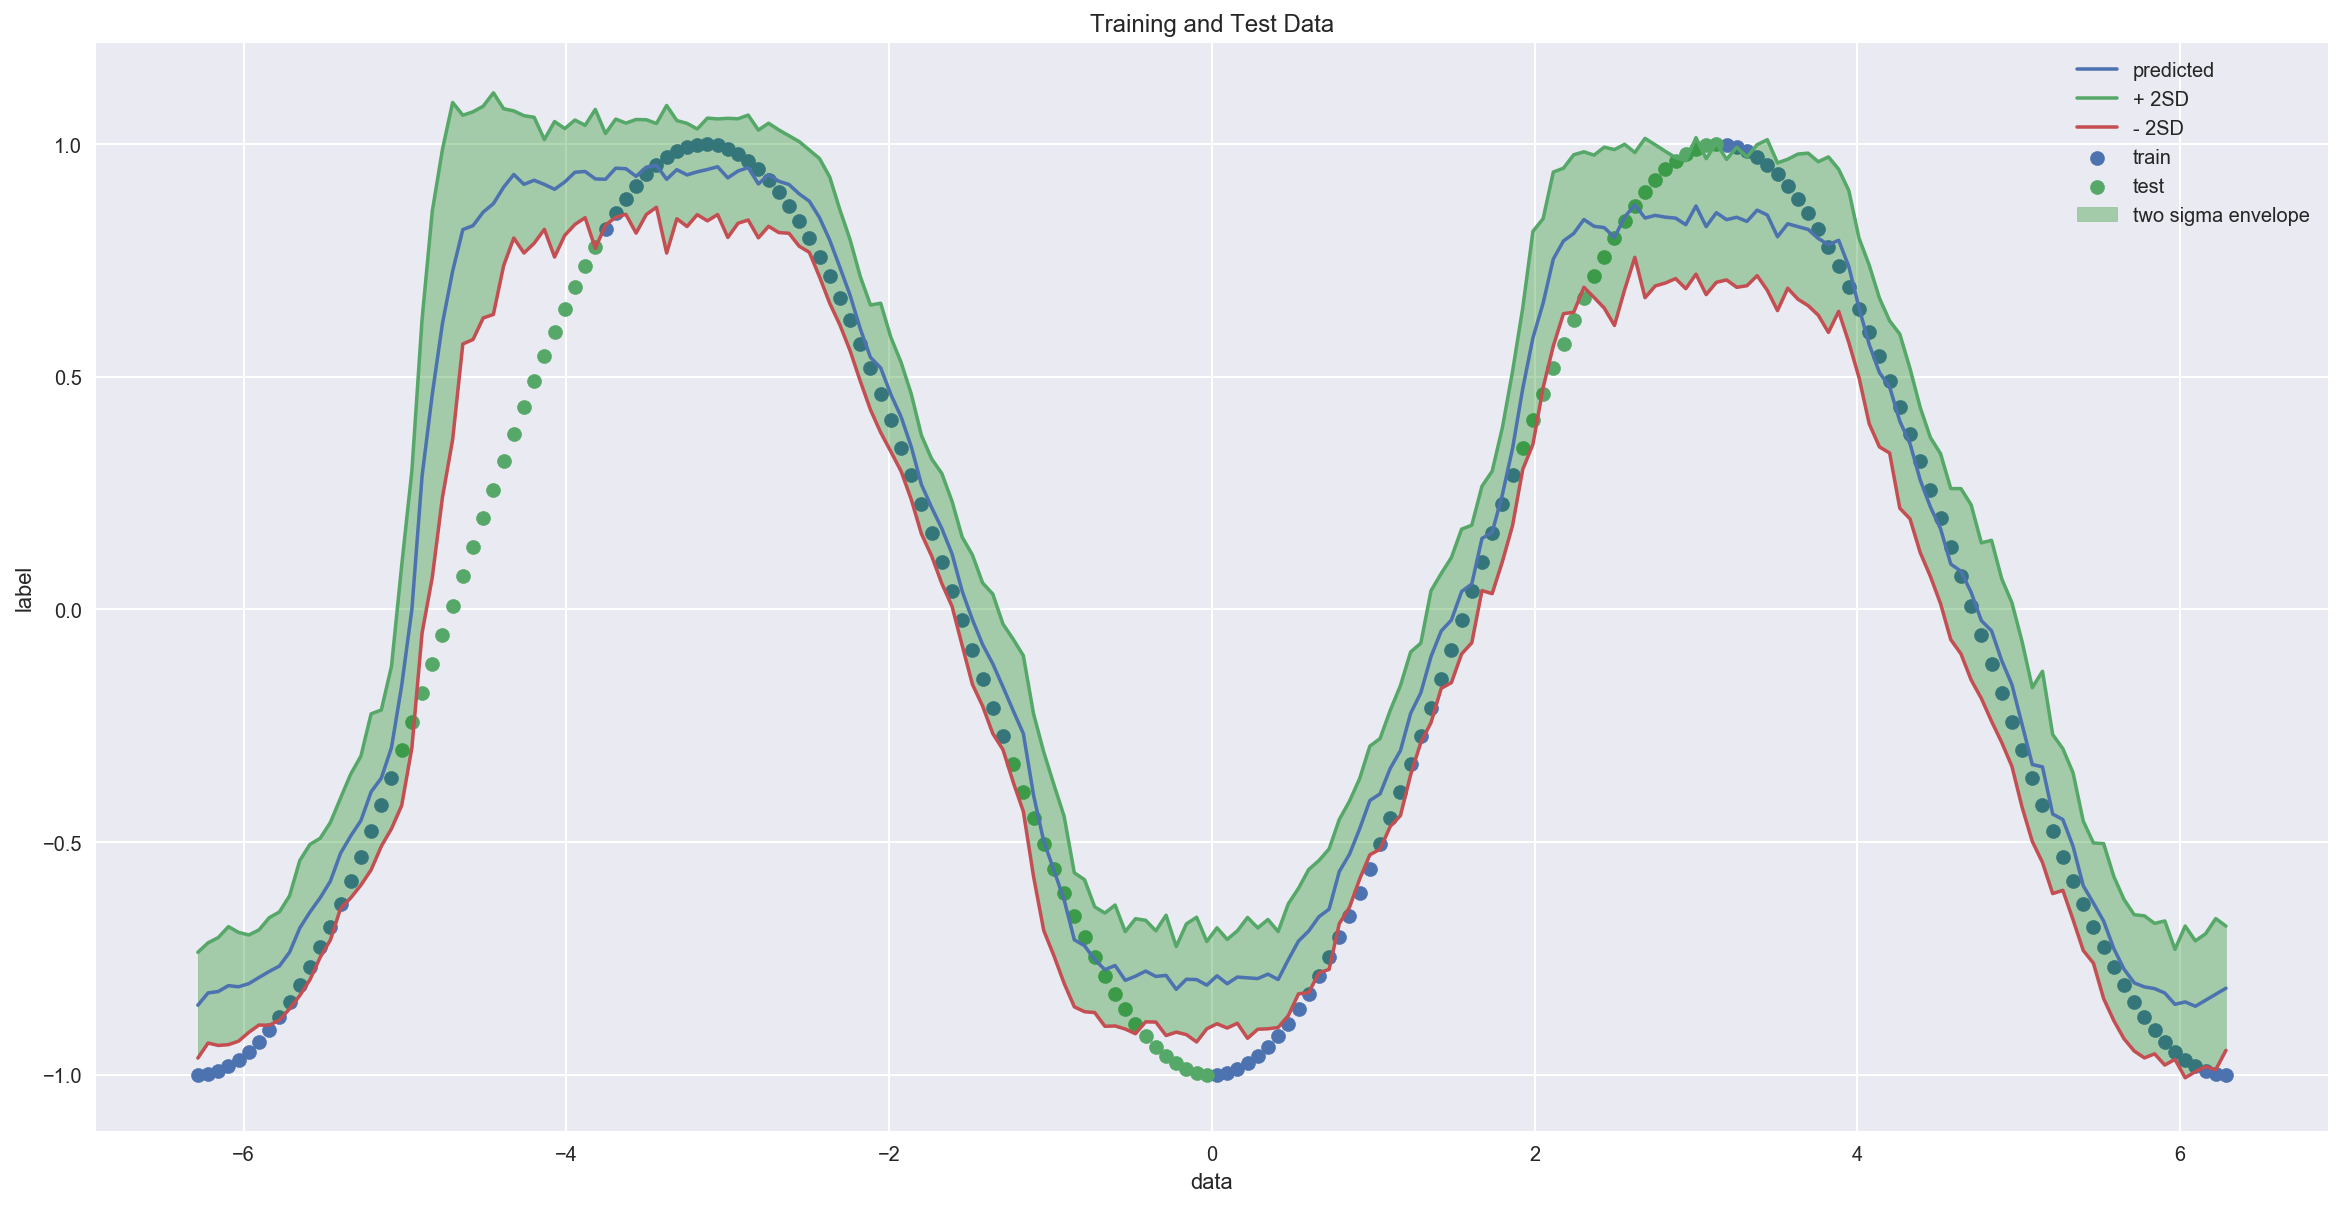

In [124]:
plt.figure(figsize=(20,10))
plt.scatter(xs_train, ys_train, label='train')
plt.scatter(xs_test, ys_test, label='test')
plt.plot(xs, ys_pred_mean, label='predicted')
plt.plot(xs, ys_pred_mean + ys_pred_sd, label='+ 2SD')
plt.plot(xs, ys_pred_mean - ys_pred_sd, label='- 2SD')
plt.fill_between(xs, ys_pred_mean - ys_pred_sd, ys_pred_mean + ys_pred_sd, color='green', alpha=0.3,
                 label="two sigma envelope")
plt.xlabel('data')
plt.ylabel('label')
plt.title('Training and Test Data')
plt.legend()
plt.show()